## ResNet Albatoin Study

TODO:
- relationship with LSTM
- multi-GPU to load 1024 case
- local lr_mult in Torch
- data preprocessing
- (trivial, no need to explicitly investigate): solvers and bn_momentum

DOING:

ls149
- n = 18, no relu
- n = 18, bn after add
- (failed) n = 200 (1202 layer), iter_size = 16, bs = 8:: even iter = 2, bs = 64, out of mem

DONE:
- depth

ISSUES:
- depth increase not consistent with performance

In [6]:
%pylab inline
#matplotlib.style.use("ggplot")
matplotlib.style.use("fivethirtyeight")

print(matplotlib.style.available)

from pygments import lexers, formatters, highlight
import lab_workbook
import pandas as pd
import collections
import os
reload(lab_workbook)

Populating the interactive namespace from numpy and matplotlib
[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


<module 'lab_workbook' from '/usr/local/lib/python2.7/dist-packages/lab_workbook/__init__.pyc'>

Basic Setup

Remember to edit the file `~/.lab-workbook-config` to choose a proper folder.

In [20]:
wb = lab_workbook.ExperimentRepository()
print wb.bucket  # show the bucket name

for i in range(size(wb[:])):
    print wb[i]

tag = '201604051455-5axGzTKG0P'
one_expe = wb[tag]

print('\nEach folder in %s contains:'% tag)
artifact = one_expe.list_artifacts()  # list type
for i in range(size(artifact)):
    print artifact[i]

opt = one_expe['opt.json']   # dict type
print('\nParameter settings in %s:' % tag)
for field, value in opt.iteritems():
    print '%s: %s' % (field, value)

<Bucket: resnet2020>
<Experiment: Apr_5_fuck>
<Experiment: 201604051455-5axGzTKG0P>
<Experiment: 201604051458-ztixNLMP1W>
<Experiment: 201604051459-0lkTlmWIi2>
<Experiment: 201604051518-KrKtiSnTJt>
<Experiment: 201604051519-kFIuH003Ig>
<Experiment: 201604051520-naxc9GH54I>
<Experiment: 201604100809-F3pSq2Ov6e>
<Experiment: 201604100815-cmlufHz7kb>
<Experiment: 201604100815-yLX1UT0nUV>

Each folder in 201604051455-5axGzTKG0P contains:
Source.git-current-commit
Source.git-patch
Testing Error.csv
Training loss.csv
model.t7
opt.json
sgdState.t7

Parameter settings in 201604051455-5axGzTKG0P:
loadFrom: 
batchSize: 64
note: N_3
Nsize: 3
dataRoot: /home/hongyang/Desktop/cifar-10-batches-t7
gpuId: 1
iterSize: 2
experimentName: snapshots/cifar-residual-experiment1


count    78516.000000
mean         0.160590
std          0.191266
min          0.003118
25%          0.032194
50%          0.070951
75%          0.254230
max          4.158943
Name: loss, dtype: float64

             loss                Date
nImages                              
0        2.534094 2016-04-05 14:55:25
128      2.480467 2016-04-05 14:55:25
256      3.874237 2016-04-05 14:55:26
384      4.158943 2016-04-05 14:55:26
512      3.156158 2016-04-05 14:55:26

[5 rows x 2 columns]


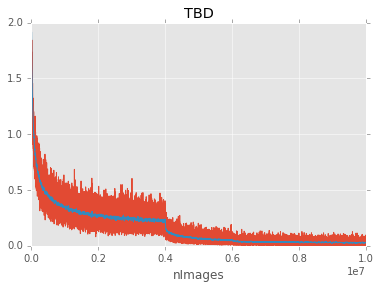

In [18]:
train = one_expe['Training loss.csv']
print train.loss.describe()
print ''
print train.head()        # you can see various field names in the table

train.loss.plot()
# or some fancy stuff
pd.rolling_mean(train['loss'], 100).plot(title="TBD", xlim=(0, 10000000), ylim=(0, 2))

### Important: Check Active Experiments

In [7]:
wb = lab_workbook.ExperimentRepository()
print wb.bucket  # show the bucket name

# find active experiments and list them here
for i in range(size(wb[:])-1):
    tag = str(os.path.basename(os.path.dirname(wb[i+1].prefix)))
    curr_expe = wb[tag]
    
    artifact = curr_expe.list_artifacts()  # list type
    
    if ('Training loss.csv' in artifact) and ('Testing Error.csv' in artifact):
        
        # active experiment, show its opts
        print '\nactive tag: %s' % tag
        opt = curr_expe['opt.json']   # dict type
        print 'batchSize: %d, iterSize: %d' % (opt['batchSize'], opt['iterSize'])
        print 'Nsize: %d' % opt['Nsize']
        print 'note: %s' % opt['note']

<Bucket: resnet2020>

active tag: 201604051520-naxc9GH54I
batchSize: 64, iterSize: 2
Nsize: 18
note: N_18_iter_size_2

active tag: 201604061025-kS3KjU59Dq
batchSize: 64, iterSize: 2
Nsize: 18
note: N_18_size_b64_i2_ls149_no_bn_and_relu

active tag: 201604101622-o1int9wyus
batchSize: 64, iterSize: 2
Nsize: 18
note: N_18_size_b64_i2_149_bn_after_add

active tag: 201604101632-0vfKNfke9l
batchSize: 64, iterSize: 2
Nsize: 18
note: N_18_size_b64_i2_149_no_relu

active tag: 201604110210-fpOCM3GQZr
batchSize: 64, iterSize: 2
Nsize: 18
note: N_18_size_b64_i2_149_no_relu


### Depth

Remember to edit the file `~/.lab-workbook-config` to choose a proper folder.

bucketPrefix = s3://resnet2020/Apr_5_fuck/

Architecture is Reference paper

bs = 64x2 = 128, depth = 20       0.0807
bs = 128, depth = 20              0.0865
bs = 128, depth = 32              0.0713
bs = 128, depth = 56              0.0763
bs = 64 x 2 = 128, depth = 110    0.0719
bs = 64 x 2 = 128, depth = 182    0.0740
Name: 200.0, dtype: float64


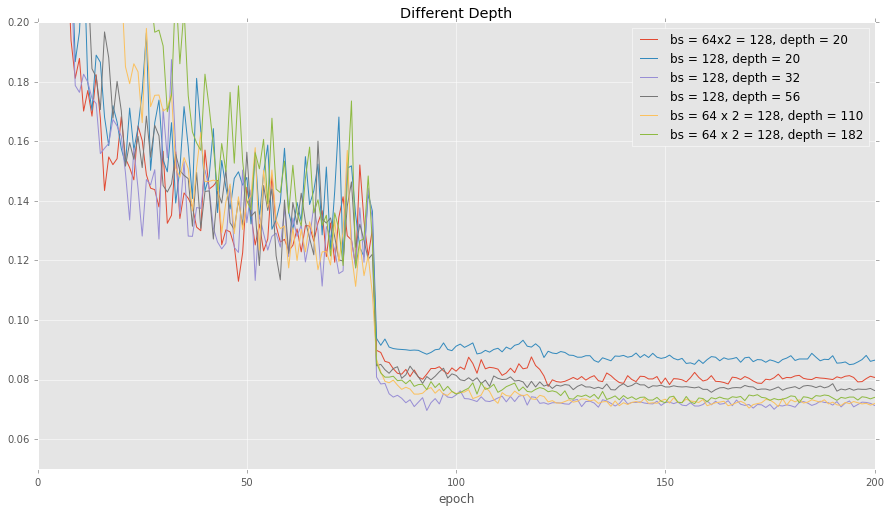

In [20]:
# configure the following manually based on the output above
experiments = collections.OrderedDict([
        ("201604051455-5axGzTKG0P", "bs = 64x2 = 128, depth = 20"),
        ("201604051459-0lkTlmWIi2", "bs = 128, depth = 20"),
        ("201604051518-KrKtiSnTJt", "bs = 128, depth = 32"),
        ("201604051519-kFIuH003Ig", "bs = 128, depth = 56"),
        ("201604051520-naxc9GH54I", "bs = 64 x 2 = 128, depth = 110"),
        ('201604060900-WupkUbhnnp', 'bs = 64 x 2 = 128, depth = 182'),       
    ])
        #('201604061025-kS3KjU59Dq', 'bs = 64 x 2 = 128, depth = 110, no bnAndRelu'),
    
error = wb.meld_csv(experiments, "Testing Error.csv", "error")
#print(type(error)) # <class 'pandas.core.frame.DataFrame'>
error.index = error.index / 50000.0
error.index.name = 'epoch'

#pd.rolling_mean(error, 10).plot(figsize=(10, 5), xlim=(0, 200))
error.plot(xlim=(0, 200), ylim=(0.05, 0.2), figsize=(15, 8), title="Different Depth")
print error.loc[200.0]

# save the results
error.to_csv("error_sort_depth.csv")

### Architecture

Note: make sure all the servers' config files are consistent with local machine, for better convenience.

all settings are bs = 64 x 2 = 128

- ('201604101632-0vfKNfke9l', 'no_relu'), failed, bad lr? (0.1, 0.01, 0.001) Nan and random guess
- new: 0.05, 0.01, 0.001

bs = 64 x 2 = 128, depth = 110                  0.0753
bs = 64 x 2 = 128, depth = 110, no bnAndRelu    0.0973
bn_after_add                                    0.2043
no_relu                                         0.0692
Name: 100.00128, dtype: float64


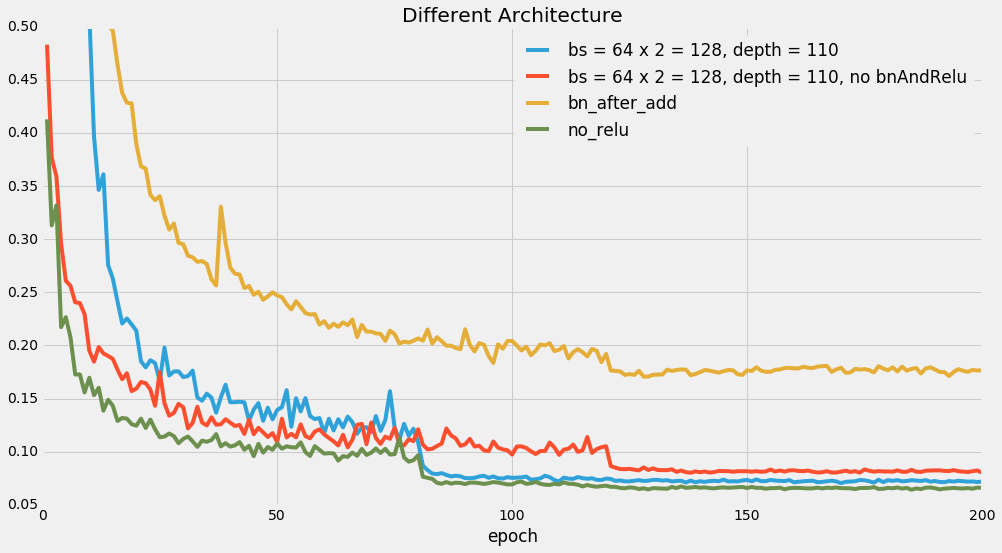

In [8]:
experiments = collections.OrderedDict([
        ("201604051520-naxc9GH54I", "bs = 64 x 2 = 128, depth = 110"),
        ('201604061025-kS3KjU59Dq', 'bs = 64 x 2 = 128, depth = 110, no bnAndRelu'), 
        ('201604101622-o1int9wyus', 'bn_after_add'),
        ('201604110210-fpOCM3GQZr', 'no_relu')
    ])

error = wb.meld_csv(experiments, "Testing Error.csv", "error")
#print(type(error)) # <class 'pandas.core.frame.DataFrame'>
error.index = error.index / 50000.0
error.index.name = 'epoch'

#pd.rolling_mean(error, 10).plot(figsize=(10, 5), xlim=(0, 200))
error.plot(xlim=(0, 200), ylim=(0.05, 0.5), figsize=(15, 8), title="Different Architecture")
print error.loc[100.0]

# save the results
error.to_csv("error_sort_archi.csv")

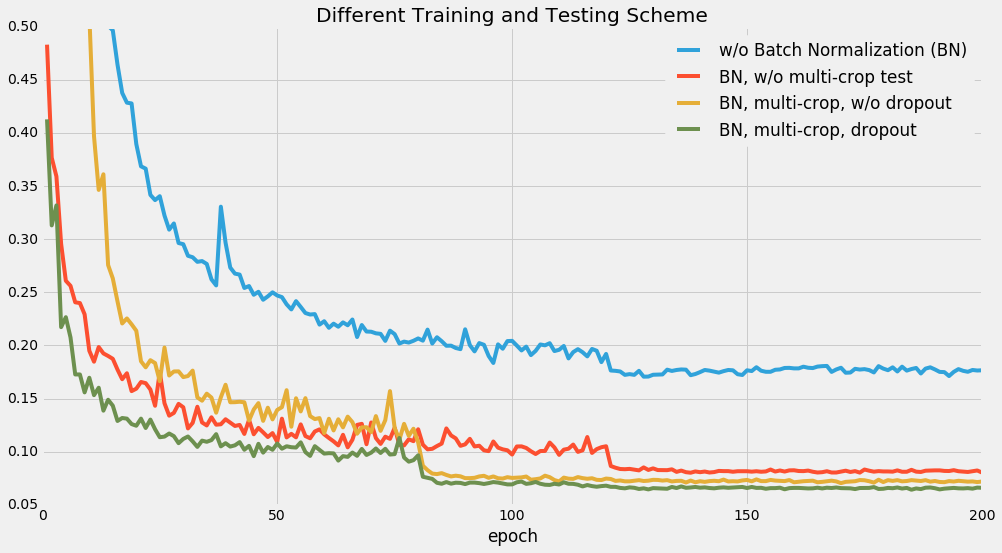

In [11]:
experiments = collections.OrderedDict([
        ("201604101622-o1int9wyus", "w/o Batch Normalization (BN)"),
        ('201604061025-kS3KjU59Dq', 'BN, w/o multi-crop test'), 
        ('201604051520-naxc9GH54I', 'BN, multi-crop, w/o dropout'),
        ('201604110210-fpOCM3GQZr', 'BN, multi-crop, dropout')
    ])

error = wb.meld_csv(experiments, "Testing Error.csv", "error")
error.index = error.index / 50000.0
error.index.name = 'epoch'
error.plot(xlim=(0, 200), ylim=(0.05, 0.5), figsize=(15, 8), title="Different Training and Testing Scheme")